In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Q1. Downloading the data

We'll use the same NYC taxi dataset, but instead of "Green Taxi Trip Records", we'll use "Yellow Taxi Trip Records".

Download the data for January and February 2022.

Read the data for January. How many columns are there?

* 19

In [3]:
df = pd.read_parquet('./data/yellow_tripdata_2022-01.parquet')
df.shape

(2463931, 19)

#### Q1. Answer: 19

## Q2. Computing duration

Now let's compute the duration variable. It should contain the duration of a ride in minutes.

What's the standard deviation of the trips duration in January?

* 46.45

In [4]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

In [5]:
df.duration.describe()

count    2.463931e+06
mean     1.421220e+01
std      4.644531e+01
min     -3.442400e+03
25%      6.316667e+00
50%      1.018333e+01
75%      1.616667e+01
max      8.513183e+03
Name: duration, dtype: float64

#### Q2. Answer: 46.45

## Q3. Dropping outliers

Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?

* 98%

In [6]:
total = df.shape[0]
df = df[(df.duration >= 1.0) & (df.duration <= 60.0)]
dropped = df.shape[0]
1 - (total-dropped)/total

0.9827547930522404

#### Q3. Answer: 98%

## Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

Turn the dataframe into a list of dictionaries
Fit a dictionary vectorizer
Get a feature matrix from it
What's the dimensionality of this matrix (number of columns)?

* 515

In [7]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [8]:
df[categorical] = df[categorical].astype(str)

In [9]:
train_dicts = df[categorical].to_dict(orient='records') # numerical

In [10]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [11]:
X_train.shape

(2421440, 515)

#### Q4. Answer: 515

## Q5. Training a model

Now let's use the feature matrix from the previous step to train a model.

Train a plain linear regression model with default parameters
Calculate the RMSE of the model on the training data
What's the RMSE on train?

* 6.99

In [12]:
target = 'duration'
y_train = df[target].values

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [14]:
y_pred = lr.predict(X_train)

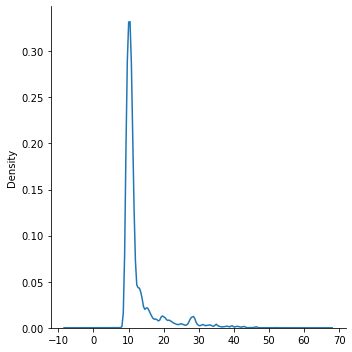

In [15]:
sns.displot(y_pred, label='prediction', kind='kde')
plt.show()

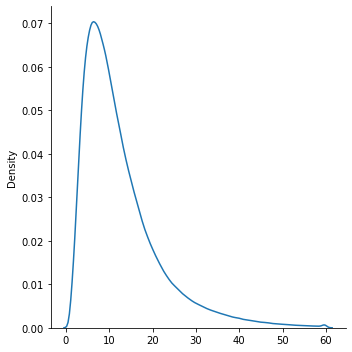

In [16]:
sns.displot(y_train, label='actual', kind='kde')
plt.show()

In [17]:
mean_squared_error(y_train, y_pred, squared=False)

6.986190743234152

#### Q5. Answer: 6.99

## Q6. Evaluating the model

Now let's apply this model to the validation dataset (February 2022).

What's the RMSE on validation?

* 7.79

In [18]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

    df = df[(df.duration >= 1.0) & (df.duration <= 60.0)]

    categorical = ['PULocationID', 'DOLocationID']

    df[categorical] = df[categorical].astype(str)
    
    return df

In [19]:
df_train = read_dataframe('./data/yellow_tripdata_2022-01.parquet')
df_val = read_dataframe('./data/yellow_tripdata_2022-02.parquet')

In [20]:
len(df_train), len(df_val)

(2421440, 2918187)

In [21]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient='records') # numerical
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient='records') # numerical
X_val = dv.transform(val_dicts)

In [22]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [23]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.786407350558637

#### Q6. Answer: 7.79

In [25]:
with open('./models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)